In [18]:
import nrrd
import os
import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import csv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, add, Conv3DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, save_model
from matplotlib.colors import ListedColormap
import Segment_support_lib

OSError: Error loading vtkh5part-9.3-1510375bcdfdd34de1a6747d2efef173.dll; The operation completed successfully.

In [2]:
crop_knee_train = 'F:\\Birva_Harsh\\Knee_Crop_Data\\train\\Knee'
crop_mask_train = 'F:\\Birva_Harsh\\Knee_Crop_Data\\train\\Mask'
crop_knee_test = 'F:\\Birva_Harsh\\Knee_Crop_Data\\test\\Knee'
crop_mask_test = 'F:\\Birva_Harsh\\Knee_Crop_Data\\test\\Mask'

In [3]:
knee_train = [os.path.join(crop_knee_train, i) for i in os.listdir(crop_knee_train)]
mask_train = [path.replace('\\Knee\\', '\\Mask\\') for path in knee_train]

knee_test = [os.path.join(crop_knee_test, i) for i in os.listdir(crop_knee_test)]
mask_test = [path.replace('\\Knee\\', '\\Mask\\') for path in knee_test]

In [4]:
df_train = pd.DataFrame( data = {
    'knee': knee_train,
    'mask': mask_train
})

df_test = pd.DataFrame( data = {
    'knee': knee_test,
    'mask': mask_test
})

In [5]:
def load_and_preprocess_image(file_path,resize):
    img,info = nrrd.read(file_path)
    if resize == 128:
        img = img[::2,::2,::2]
    img = np.clip(img, a_min=-1024, a_max=None)
    img = img[:,:,:,np.newaxis]   
    img_scaled = img.astype(np.float32) / 1024.0
    return img_scaled

In [6]:
def load_and_preprocess_mask(file_path,resize):
    img,info = nrrd.read(file_path)
    if resize == 128:
        img = img[::2,::2,::2]
    
    img_1 = np.where(img == 1, 1, 0)
    img_2 = np.where(img == 2, 1, 0)
    img_3 = np.where(img == 3, 1, 0)
    
    mask = np.stack((img_1, img_2, img_3), axis=-1)
    mask = mask.astype(np.float32)
    return mask

In [7]:
def generate_data_generator(dataframe,resize, batch_size=1):
    num_samples = len(dataframe)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_knee = []
        batch_mask = []
        for idx in indices:
            knee_img = load_and_preprocess_image(dataframe.iloc[idx]['knee'],resize)
            mask_img = load_and_preprocess_mask(dataframe.iloc[idx]['mask'],resize)
            batch_knee.append(knee_img)
            batch_mask.append(mask_img)
        batch_knee = np.array(batch_knee)
        batch_mask = np.array(batch_mask)
        
        yield batch_knee, batch_mask

In [8]:
batch_size = 1
train_generator = generate_data_generator(df_train, batch_size=batch_size,resize=256)
test_generator = generate_data_generator(df_test, batch_size=batch_size,resize=256)

In [9]:
def dice_coeff(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coeff_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coeff(y_true, y_pred, smooth)

In [10]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)
    return dice    

In [11]:
def encoder_block(inputs, filters):
    conv = Conv3D(filters, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(inputs)
    conv = Conv3D(filters, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(conv)
    x = BatchNormalization()(conv)
    pool = MaxPooling3D(pool_size=(2,2,2), padding="same")(x)
    
    return pool,x

def decoder_block(inputs, filters, x):
    up = Conv3DTranspose(filters, kernel_size=(3,3,3), strides=(2, 2, 2), padding="same", kernel_initializer='he_uniform')(inputs)
    con = concatenate([up, x])
    conv = Conv3D(filters, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(con)
    conv = Conv3D(filters, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(conv)
    x = BatchNormalization()(conv)
    
    return x

# Pocket Net

In [ ]:
f = 16

In [ ]:
def Pocketnet_16(input_shape = (None, None, None, 1)):
    inputs = Input(input_shape)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    
    b1,c1 = encoder_block(x, f)
    b2,c2 = encoder_block(b1, f)
    b3,c3 = encoder_block(b2, f)
    b4,c4 = encoder_block(b3, f)

    conv = Conv3D(f, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(b4)
    conv = Conv3D(f, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(conv)

    b4 = decoder_block(conv, f, c4)
    b5 = decoder_block(b4, f, c3)
    b6 = decoder_block(b5, f, c2)
    b7 = decoder_block(b6, f, c1)
    
    outputs = Conv3D(filters = 3, kernel_size = (1,1,1), activation = "sigmoid")(b7)
    
    return Model(inputs=[inputs], outputs = [outputs])

In [ ]:
filepath = "F:\\Birva_Harsh\\Knee_models\\pocketnet_256_32_new.keras"

checkpoint = ModelCheckpoint(filepath, 
                             verbose=1 
                             )

In [ ]:
pocket_16 = Pocketnet_16(input_shape = (None,None,None,1))
pocket_16.compile(optimizer='adam', loss=dice_coeff_loss, metrics=[dice_coeff])

In [ ]:
epochs = 50

In [ ]:
history = pocket_16.fit(
        train_generator,
        steps_per_epoch=len(df_train) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint],
        validation_data=test_generator,
        validation_steps=len(df_test) // batch_size
    )

# U-Net

In [ ]:
f = 16

In [ ]:
def Unet_8(input_shape = (None, None, None, 1)):
    inputs = Input(input_shape)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    
    b1,c1 = encoder_block(x, f)
    b2,c2 = encoder_block(b1, f)
    b3,c3 = encoder_block(b2, f*2)
    b4,c4 = encoder_block(b3, f*2)

    conv = Conv3D(f*4, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(b4)
    conv = Conv3D(f*4, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(conv)

    b4 = decoder_block(conv, f*2, c4)
    b5 = decoder_block(b4, f*2, c3)
    b6 = decoder_block(b5, f, c2)
    b7 = decoder_block(b6, f, c1)
    
    outputs = Conv3D(filters = 3, kernel_size = (1,1,1), activation = "sigmoid")(b7)
    
    return Model(inputs=[inputs], outputs = [outputs])

In [ ]:
filepath = "F:\\Birva_Harsh\\Knee_models\\new_unet_256_16.keras"

checkpoint = ModelCheckpoint(filepath, 
                             verbose=1 
                             )

In [ ]:
unet_8 = Unet_8(input_shape = (None,None,None,1))
unet_8.compile(optimizer='adam', loss=dice_coeff_loss, metrics=[dice_coeff])

In [ ]:
epochs = 50

In [ ]:
history = unet_8.fit(
        train_generator,
        steps_per_epoch=len(df_train) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint],
        validation_data=test_generator,
        validation_steps=len(df_test) // batch_size
    )

# Resnet Type Net (Filters=16) with branch

In [ ]:
def encoder_block(inputs, f):
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(conv)
    pool = MaxPooling3D(pool_size=(2,2,2), padding="same")(conv)

    return pool,conv

def decoder_block(inputs, f, x):
    up = Conv3DTranspose(f, kernel_size=(3,3,3), strides=(2, 2, 2), padding="same", kernel_initializer='he_uniform')(inputs)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(up)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(conv)

    if x is not None:
        x = BatchNormalization()(x)
        conv = BatchNormalization()(conv)
        conv = add([x, conv])

    return conv

In [ ]:
def u_block(inputs, f):
    b1,c1 = encoder_block(inputs, f)
    b2,c2 = encoder_block(b1, f)

    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(b2)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(conv)

    b4 = decoder_block(conv, f,None)
    b5 = decoder_block(b4, f, c1)

    return b5

In [ ]:
f = 16
num_blocks = 3

In [ ]:
def res_type_16(input_shape = (None,None,None, 1)):

    inputs = Input(input_shape)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2,2,2), padding="same")(x)

    for i in range(num_blocks):
        x = u_block(x,f)
        b = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
        b = BatchNormalization()(b)
        b = MaxPooling3D(pool_size=(2,2,2), padding="same")(b)
        x = add([x, b])

    x = Conv3DTranspose(f, kernel_size=(3,3,3), strides=(2, 2, 2), padding="same", kernel_initializer='he_uniform')(x)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(x)
    outputs = Conv3D(filters = 3, kernel_size = (1,1,1), activation = "sigmoid")(x)
    
    return Model(inputs=[inputs], outputs = [outputs])

In [ ]:
epochs=50

In [ ]:
filepath = "F:\\Birva_Harsh\\Knee_models\\restype_16.keras"

checkpoint = ModelCheckpoint(filepath, 
                             verbose=1 
                             )

75/75 [==============================] - 120s 2s/step - loss: 0.1167 - dice_coeff: 0.8833 - val_loss: 0.3551 - val_dice_coeff: 0.6449
Epoch 9/50
75/75 [==============================] - ETA: 0s - loss: 0.1202 - dice_coeff: 0.8798
Epoch 9: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-4.keras
75/75 [==============================] - 119s 2s/step - loss: 0.1202 - dice_coeff: 0.8798 - val_loss: 0.2473 - val_dice_coeff: 0.7527
Epoch 10/50
75/75 [==============================] - ETA: 0s - loss: 0.1121 - dice_coeff: 0.8879
Epoch 10: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-4.keras
75/75 [==============================] - 119s 2s/step - loss: 0.1121 - dice_coeff: 0.8879 - val_loss: 0.1470 - val_dice_coeff: 0.8530
Epoch 11/50
75/75 [==============================] - ETA: 0s - loss: 0.1111 - dice_coeff: 0.8889
Epoch 11: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-4.keras
75/75 [=============================

75/75 [==============================] - ETA: 0s - loss: 0.0959 - dice_coeff: 0.9041
Epoch 34: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-4.keras
75/75 [==============================] - 119s 2s/step - loss: 0.0959 - dice_coeff: 0.9041 - val_loss: 0.1290 - val_dice_coeff: 0.8710
Epoch 35/50
75/75 [==============================] - ETA: 0s - loss: 0.0982 - dice_coeff: 0.9018
Epoch 35: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-4.keras
75/75 [==============================] - 105s 1s/step - loss: 0.0982 - dice_coeff: 0.9018 - val_loss: 0.1123 - val_dice_coeff: 0.8877
Epoch 36/50
75/75 [==============================] - ETA: 0s - loss: 0.0994 - dice_coeff: 0.9006
Epoch 36: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-4.keras
75/75 [==============================] - 105s 1s/step - loss: 0.0994 - dice_coeff: 0.9006 - val_loss: 0.1111 - val_dice_coeff: 0.8889
Epoch 37/50
75/75 [===========================

1/1 [==============================] - 0s 46ms/step
Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.5442 - dice_coeff: 0.4558
Epoch 1: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 126s 2s/step - loss: 0.5442 - dice_coeff: 0.4558 - val_loss: 0.9679 - val_dice_coeff: 0.0321
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.2405 - dice_coeff: 0.7595
Epoch 2: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras


75/75 [==============================] - 106s 1s/step - loss: 0.2405 - dice_coeff: 0.7595 - val_loss: 0.9941 - val_dice_coeff: 0.0059
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.1777 - dice_coeff: 0.8223
Epoch 3: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 120s 2s/step - loss: 0.1777 - dice_coeff: 0.8223 - val_loss: 0.9967 - val_dice_coeff: 0.0033
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.1552 - dice_coeff: 0.8448
Epoch 4: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 106s 1s/step - loss: 0.1552 - dice_coeff: 0.8448 - val_loss: 0.9919 - val_dice_coeff: 0.0081
Epoch 5/50
75/75 [==============================] - ETA: 0s - loss: 0.1357 - dice_coeff: 0.8643
Epoch 5: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] -

75/75 [==============================] - ETA: 0s - loss: 0.0978 - dice_coeff: 0.9022
Epoch 28: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 105s 1s/step - loss: 0.0978 - dice_coeff: 0.9022 - val_loss: 0.1297 - val_dice_coeff: 0.8703
Epoch 29/50
75/75 [==============================] - ETA: 0s - loss: 0.0993 - dice_coeff: 0.9007
Epoch 29: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 120s 2s/step - loss: 0.0993 - dice_coeff: 0.9007 - val_loss: 0.1205 - val_dice_coeff: 0.8795
Epoch 30/50
75/75 [==============================] - ETA: 0s - loss: 0.0996 - dice_coeff: 0.9004
Epoch 30: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 120s 2s/step - loss: 0.0996 - dice_coeff: 0.9004 - val_loss: 0.1315 - val_dice_coeff: 0.8685
Epoch 31/50
75/75 [===========================

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


In [ ]:
restype_16 = res_type_16(input_shape = (None,None,None,1))
restype_16.compile(optimizer='adam', loss=dice_coeff_loss, metrics=[dice_coeff])

In [ ]:
restype_16.summary()

In [ ]:
history = restype_16.fit(
        train_generator,
        steps_per_epoch=len(df_train) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint],
        validation_data=test_generator,
        validation_steps=len(df_test) // batch_size
    )

# Resnet Type Net (Filters=16) without branch

In [40]:
def encoder_block(inputs, f):
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(conv)
    pool = MaxPooling3D(pool_size=(2,2,2), padding="same")(conv)

    return pool,conv

def decoder_block(inputs, f, x):
    up = Conv3DTranspose(f, kernel_size=(3,3,3), strides=(2, 2, 2), padding="same", kernel_initializer='he_uniform')(inputs)
    if x is not None:
        x = BatchNormalization()(x)
        conv = BatchNormalization()(up)
        up = add([x, conv])
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(up)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(conv)

    return conv

In [41]:
def u_block(inputs, f):
    b1,c1 = encoder_block(inputs, f)
    b2,c2 = encoder_block(b1, f)

    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(b2)
    conv = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(conv)

    b4 = decoder_block(conv, f,None)
    b5 = decoder_block(b4, f, c1)

    return b5

In [42]:
f = 16
num_blocks = 4

In [43]:
def res_type_16(input_shape = (None,None,None, 1)):

    inputs = Input(input_shape)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2,2,2), padding="same")(x)

    for i in range(num_blocks):
        x = u_block(x,f)

    x = Conv3DTranspose(f, kernel_size=(3,3,3), strides=(2, 2, 2), padding="same", kernel_initializer='he_uniform')(x)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(x)
    outputs = Conv3D(filters = 3, kernel_size = (1,1,1), activation = "sigmoid")(x)
    
    return Model(inputs=[inputs], outputs = [outputs])

In [44]:
epochs=50

In [45]:
filepath = "F:\\Birva_Harsh\\Knee_models\\restype_16_no_branch-2.keras"

checkpoint = ModelCheckpoint(filepath, 
                             verbose=1 
                             )

75/75 [==============================] - 106s 1s/step - loss: 0.2405 - dice_coeff: 0.7595 - val_loss: 0.9941 - val_dice_coeff: 0.0059
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.1777 - dice_coeff: 0.8223
Epoch 3: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 120s 2s/step - loss: 0.1777 - dice_coeff: 0.8223 - val_loss: 0.9967 - val_dice_coeff: 0.0033
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.1552 - dice_coeff: 0.8448
Epoch 4: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 106s 1s/step - loss: 0.1552 - dice_coeff: 0.8448 - val_loss: 0.9919 - val_dice_coeff: 0.0081
Epoch 5/50
75/75 [==============================] - ETA: 0s - loss: 0.1357 - dice_coeff: 0.8643
Epoch 5: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] -

75/75 [==============================] - ETA: 0s - loss: 0.0978 - dice_coeff: 0.9022
Epoch 28: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 105s 1s/step - loss: 0.0978 - dice_coeff: 0.9022 - val_loss: 0.1297 - val_dice_coeff: 0.8703
Epoch 29/50
75/75 [==============================] - ETA: 0s - loss: 0.0993 - dice_coeff: 0.9007
Epoch 29: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 120s 2s/step - loss: 0.0993 - dice_coeff: 0.9007 - val_loss: 0.1205 - val_dice_coeff: 0.8795
Epoch 30/50
75/75 [==============================] - ETA: 0s - loss: 0.0996 - dice_coeff: 0.9004
Epoch 30: saving model to G:\Harsh_Birva_minor_Proj\new_retina_models_5\restype_16-5.keras
75/75 [==============================] - 120s 2s/step - loss: 0.0996 - dice_coeff: 0.9004 - val_loss: 0.1315 - val_dice_coeff: 0.8685
Epoch 31/50
75/75 [===========================

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


In [46]:
restype_16 = res_type_16(input_shape = (None,None,None,1))
restype_16.compile(optimizer='adam', loss=dice_coeff_loss, metrics=[dice_coeff])

In [47]:
restype_16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_16 (Conv3D)             (None, None, None,   448         ['input_3[0][0]']                
                                None, 16)                                                         
                                                                                                  
 batch_normalization_2 (BatchNo  (None, None, None,   64         ['conv3d_16[0][0]']              
 rmalization)                   None, 16)                                                     

In [48]:
history = restype_16.fit(
        train_generator,
        steps_per_epoch=len(df_train) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint],
        validation_data=test_generator,
        validation_steps=len(df_test) // batch_size
    )

Epoch 1/50
350/350 [==============================] - ETA: 0s - loss: 0.3423 - dice_coeff: 0.6577
Epoch 1: saving model to F:\Birva_Harsh\Knee_models\restype_16_no_branch-2.keras
350/350 [==============================] - 349s 994ms/step - loss: 0.3423 - dice_coeff: 0.6577 - val_loss: 0.2182 - val_dice_coeff: 0.7818
Epoch 2/50
350/350 [==============================] - ETA: 0s - loss: 0.1395 - dice_coeff: 0.8605
Epoch 2: saving model to F:\Birva_Harsh\Knee_models\restype_16_no_branch-2.keras
350/350 [==============================] - 343s 981ms/step - loss: 0.1395 - dice_coeff: 0.8605 - val_loss: 0.1960 - val_dice_coeff: 0.8040
Epoch 3/50
350/350 [==============================] - ETA: 0s - loss: 0.1207 - dice_coeff: 0.8793
Epoch 3: saving model to F:\Birva_Harsh\Knee_models\restype_16_no_branch-2.keras
350/350 [==============================] - 353s 1s/step - loss: 0.1207 - dice_coeff: 0.8793 - val_loss: 0.1821 - val_dice_coeff: 0.8179
Epoch 4/50
350/350 [=============================

# Dice Score

In [12]:
df_test = df_test.reset_index(drop=True)

In [23]:
model = tf.keras.models.load_model("F:\\Birva_Harsh\\Knee_models\\pocketnet_256_32_new.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})

In [24]:
def plot_3d(model,img_path,mask_path,resize):
    colors = ['black', 'red', 'lime', 'royalblue']
    
    cmap = ListedColormap(colors)
    norm = plt.cm.colors.Normalize(vmin=0, vmax=3)
    
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    pred_mask = model.predict(img)
    
    mask,minfo = nrrd.read(mask_path)
    if resize == 128:
        mask = mask[::2,::2,::2]
    
    img = np.squeeze(img)
    mask = np.squeeze(mask)
   
    m1 = pred_mask[:,:,:,:,0]
    m2 = pred_mask[:,:,:,:,1]
    m3 = pred_mask[:,:,:,:,2]
    
    max_values = np.maximum(np.maximum(m1, m2), m3)
    m1[m1 < 0.5] = 0
    m2[m2 < 0.5] = 0
    m3[m3 < 0.5] = 0
    
    mask1 = (m1 == max_values)
    mask2 = (m2 == max_values)
    mask3 = (m3 == max_values)
    
    p1 = (np.where(mask1, m1, 0)>=0.5).astype(np.uint8)
    p2 = (np.where(mask2, m2, 0)>=0.5).astype(np.uint8)
    p3 = (np.where(mask3, m3, 0)>=0.5).astype(np.uint8)
    
    p1 = np.where(p1 == 1,1,0)
    p2 = np.where(p2 == 1,2,0)
    p3 = np.where(p3 == 1,3,0)
    #print(p1.shape)
    #Segment_support_lib.get_3D_mesh(np.squeeze(p1),None,'femur')
    #Segment_support_lib.get_3D_mesh(np.squeeze(p2),None,'patella')
    #Segment_support_lib.get_3D_mesh(np.squeeze(p3),None,'tibia')
    
    pred_m = p1+p2+p3
    pred_m = np.squeeze(pred_m)
   
    
    
    plt.figure(figsize=(18,12))
    plt.subplot(3, 3, 1)
    plt.imshow(img[resize//2,:,:].T,cmap='gray')
    plt.axis('off')
    plt.title("X")
    
    plt.subplot(3, 3, 2)
    plt.imshow(img[:,resize//2,:].T,cmap='gray')
    plt.axis('off')
    plt.title("Y")
    
    plt.subplot(3, 3, 3)
    plt.imshow(img[:,:,resize//2].T,cmap='gray')
    plt.axis('off')
    plt.title("Z")
    
    
    plt.subplot(3, 3, 4)
    plt.imshow(mask[resize//2,:,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Mask X")
    
    plt.subplot(3, 3, 5)
    plt.imshow(mask[:,resize//2,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Mask Y")
    
    plt.subplot(3, 3, 6)
    plt.imshow(mask[:,:,resize//2].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Mask Z")
    
    plt.subplot(3, 3, 7)
    plt.imshow(pred_m[resize//2,:,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Pred Mask X")
    
    plt.subplot(3, 3, 8)
    plt.imshow(pred_m[:,resize//2,:].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Pred Mask Y")
    
    plt.subplot(3, 3, 9)
    plt.imshow(pred_m[:,:,resize//2].T,interpolation='nearest',cmap=cmap,norm=norm)
    plt.axis('off')
    plt.title("Pred Mask Z")
plt.show()

1/1 [==============================] - 0s 58ms/step


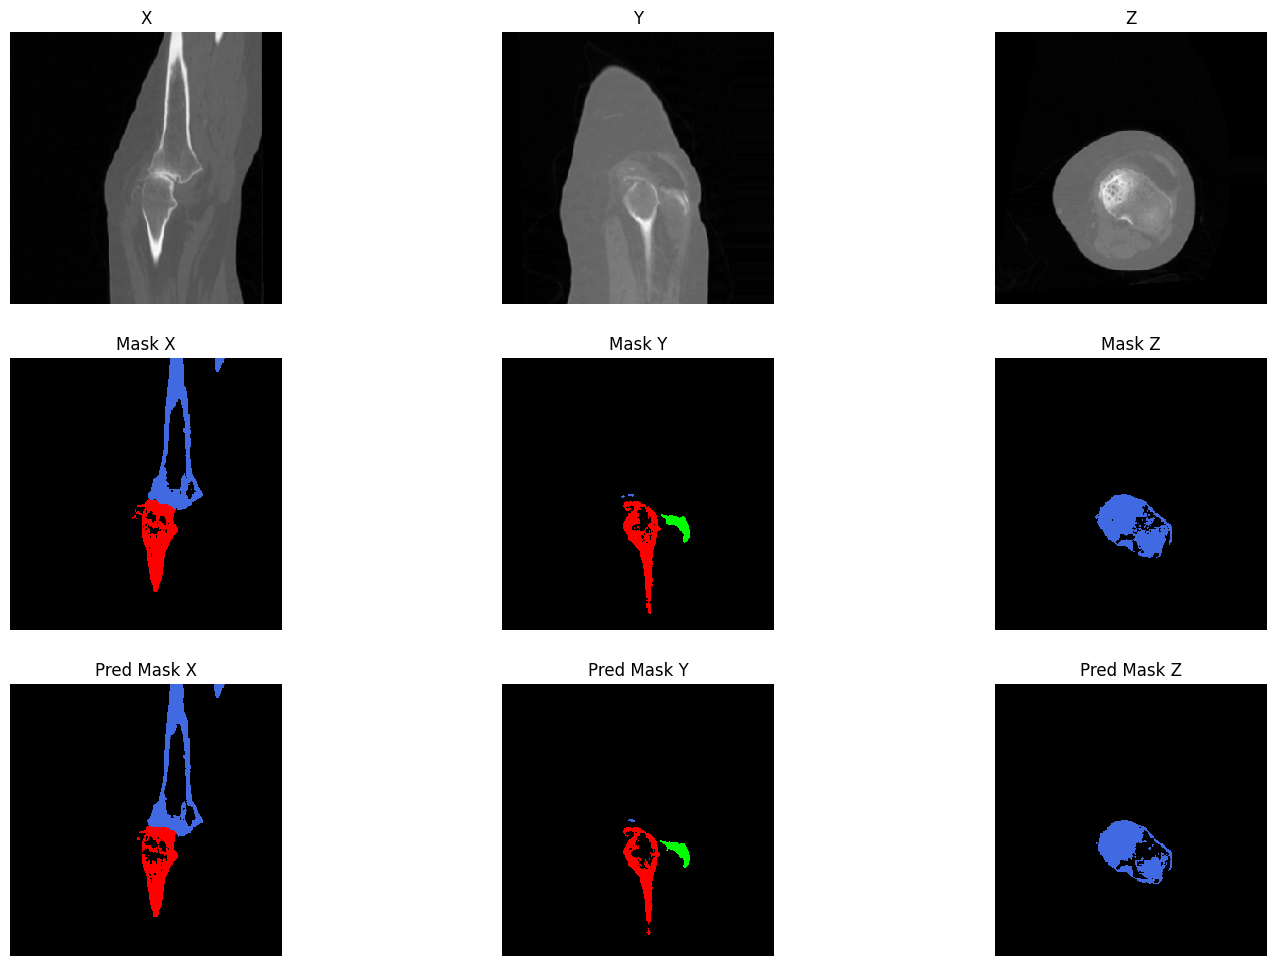

In [27]:
index = np.random.randint(0, len(df_test.index))
plot_3d(model,df_test.loc[11,'knee'],df_test.loc[11,'mask'],256)

In [22]:
index

12

In [ ]:
def preprocess(img_path,mask_path,resize):
    img = load_and_preprocess_image(img_path,resize)
    img = img[np.newaxis,:,:,:,:]
    pred_mask = model.predict(img)
    
    mask,minfo = nrrd.read(mask_path)
    if resize == 128:
        mask = mask[::2,::2,::2]

    img = np.squeeze(img)
    mask = np.squeeze(mask)

    m1 = pred_mask[:,:,:,:,0]
    m2 = pred_mask[:,:,:,:,1]
    m3 = pred_mask[:,:,:,:,2]

    max_values = np.maximum(np.maximum(m1, m2), m3)
    
    m1[m1 < 0.5] = 0
    m2[m2 < 0.5] = 0
    m3[m3 < 0.5] = 0

    mask1 = (m1 == max_values)
    mask2 = (m2 == max_values)
    mask3 = (m3 == max_values)

    p1 = (np.where(mask1, m1, 0)>=0.5).astype(np.uint8)
    p2 = (np.where(mask2, m2, 0)>=0.5).astype(np.uint8)
    p3 = (np.where(mask3, m3, 0)>=0.5).astype(np.uint8)

    p1 = np.where(p1 == 1,1,0)
    p2 = np.where(p2 == 1,2,0)
    p3 = np.where(p3 == 1,3,0)

    pred_m = p1+p2+p3
    pred_m = np.squeeze(pred_m)
    
    return mask,pred_m

In [16]:
femur = []
patella = []
tibia = []

for i in range(100):
    mask, pred_m = preprocess(df_test.loc[i,'knee'],df_test.loc[i,'mask'],256)

    c1 = np.where(mask == 1,1,0)
    pred_c1 = np.where(pred_m == 1,1,0)

    c2 = np.where(mask == 2,1,0)
    pred_c2 = np.where(pred_m == 2,1,0)

    c3 = np.where(mask == 3,1,0)
    pred_c3 = np.where(pred_m == 3,1,0)
    
    tibia.append(DICE_COE(pred_c1,c1))
    patella.append(DICE_COE(pred_c2,c2))
    femur.append(DICE_COE(pred_c3,c3))

NameError: name 'preprocess' is not defined

In [ ]:
plt.figure(figsize=(18,12))
plt.subplot(1, 3, 1)
plt.imshow(pred_c1[128,:,:].T,cmap='gray')
plt.axis('off')
plt.title("c1")

plt.subplot(1, 3, 2)
plt.imshow(pred_c2[128,:,:].T,cmap='gray')
plt.axis('off')
plt.title("c2")

plt.subplot(1, 3, 3)
plt.imshow(pred_c3[128,:,:].T,cmap='gray')
plt.axis('off')
plt.title("c3")

In [ ]:
print(f"Femur Dice : {np.round(np.mean(femur),3)}")
print(f"Patella Dice : {np.round(np.mean(patella),3)}")
print(f"Tibia Dice : {np.round(np.mean(tibia),3)}")

In [ ]:
f = 8

In [ ]:
def Pocketnet_8(input_shape = (None, None, None, 1)):
    inputs = Input(input_shape)
    x = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    
    b1,c1 = encoder_block(x, f)
    b2,c2 = encoder_block(b1, f)
    b3,c3 = encoder_block(b2, f)
    b4,c4 = encoder_block(b3, f)

    conv = Conv3D(f, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(b4)
    conv = Conv3D(f, kernel_size = (3,3,3), padding="same", activation = 'relu', kernel_initializer='he_uniform')(conv)

    b4 = decoder_block(conv, f, c4)
    b5 = decoder_block(b4, f, c3)
    b6 = decoder_block(b5, f, c2)
    b7 = decoder_block(b6, f, c1)
    
    outputs = Conv3D(filters = 3, kernel_size = (1,1,1), activation = "sigmoid")(b7)
    
    return Model(inputs=[inputs], outputs = [outputs])

In [ ]:
filepath = "F:\\Birva_Harsh\\Knee_models\\pocketnet_256_8.keras"

checkpoint = ModelCheckpoint(filepath, 
                             verbose=1 
                             )

In [ ]:
pocket_8 = Pocketnet_8(input_shape = (None,None,None,1))
pocket_8.compile(optimizer='adam', loss=dice_coeff_loss, metrics=[dice_coeff])

In [ ]:
epochs = 50

In [ ]:
history = pocket_8.fit(
        train_generator,
        steps_per_epoch=len(df_train) // batch_size,
        epochs=epochs,
        callbacks=[checkpoint],
        validation_data=test_generator,
        validation_steps=len(df_test) // batch_size
    )

In [ ]:
index = np.random.randint(0, len(df_test.index))
plot_3d(pocket_8,df_test.loc[index,'knee'],df_test.loc[index,'mask'],256)